In [1]:
# Seção 1: Importação de bibliotecas
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

# Configurações de visualização
sns.set(style="whitegrid")

In [2]:

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../credentials.json'

# Seção 2: Conexão com o BigQuery
client = bigquery.Client()

In [3]:
# Seção 3: Consulta SQL para coletar dados
query = """
    SELECT
        event_date,
        event_timestamp,
        event_bundle_sequence_id,
        event_name,
        user_pseudo_id,
        geo.country AS country,
        traffic_source.source AS traffic_source,
        device.category AS device_category,
        ecommerce.total_item_quantity,
        ecommerce.purchase_revenue_in_usd,
        ecommerce.transaction_id,
        --items
    FROM
        `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20201101' AND '20210131'
        AND event_name IN ('purchase', 'add_to_cart', 'view_item', 'begin_checkout')
"""
df = client.query(query).to_dataframe()

c:\Users\pedro\anaconda3\envs\ecommerce\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


## 2. Pré-processamento

- Tratar datas
- Normalizar nomes de eventos
- Criar identificadores únicos por sessão e usuário (user_pseudo_id, event_bundle_sequence_id)
- Agrupar eventos por sessão para reconstruir funis de navegação

In [4]:
# Converter a data do evento para datetime
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y%m%d')

# Normalizar nomes dos eventos
df['event_name'] = df['event_name'].str.lower().str.replace(" ", "_")

# Criar identificador único de sessão
df['session_id'] = df['user_pseudo_id'] + "_" + df['event_bundle_sequence_id'].astype(str)

# Exibir exemplos
df[['user_pseudo_id', 'event_bundle_sequence_id', 'session_id']].head()

,user_pseudo_id,event_bundle_sequence_id,session_id
0,1023282.4639847710,-9045817540,1023282.4639847710_-9045817540
1,1023282.4639847710,-3895291055,1023282.4639847710_-3895291055
2,1023282.4639847710,3245511406,1023282.4639847710_3245511406
3,1023282.4639847710,807979399,1023282.4639847710_807979399
4,1112823.8475775772,1475550571,1112823.8475775772_1475550571


In [5]:
# Agrupar eventos por sessão para reconstruir jornadas
session_events = df.groupby('session_id')['event_name'].apply(list).reset_index()
session_events.head()

,session_id,event_name
0,10007643.0797593935_-9649825160,[view_item]
1,10010971.4068667823_-2137537811,[view_item]
2,1001212.6261056431_-5403165018,[view_item]
3,1001303.4827739208_-1166971591,[view_item]
4,1001303.4827739208_-3576100944,[view_item]


## 3. Exploração de Dados (EDA)

KPIs principais:

- Número de sessões
- Taxa de conversão
- CAC (estimado via canais de origem)
- Receita por canal
- Tempo médio até a compra

In [6]:
# Número de sessões
num_sessoes = df['session_id'].nunique()
print("Número de sessões únicas:", num_sessoes)

Número de sessões únicas: 107587


In [7]:
# Taxa de conversão: sessões com 'purchase' dividido pelo total de sessões
sessions_with_purchase = df[df['event_name'] == 'purchase']['session_id'].nunique()
taxa_conversao = sessions_with_purchase / num_sessoes
print(f"Taxa de conversão: {taxa_conversao:.2%}")

Taxa de conversão: 1.12%


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114731 entries, 0 to 114730
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   event_date                114731 non-null  datetime64[ns]
 1   event_timestamp           114731 non-null  Int64         
 2   event_bundle_sequence_id  114731 non-null  Int64         
 3   event_name                114731 non-null  object        
 4   user_pseudo_id            114731 non-null  object        
 5   country                   114731 non-null  object        
 6   traffic_source            114731 non-null  object        
 7   device_category           114731 non-null  object        
 8   total_item_quantity       20959 non-null   Int64         
 9   purchase_revenue_in_usd   1204 non-null    float64       
 10  transaction_id            114731 non-null  object        
 11  session_id                114731 non-null  object        
dtypes:

<Axes: title={'center': 'Receita por canal de origem'}, xlabel='traffic_source'>

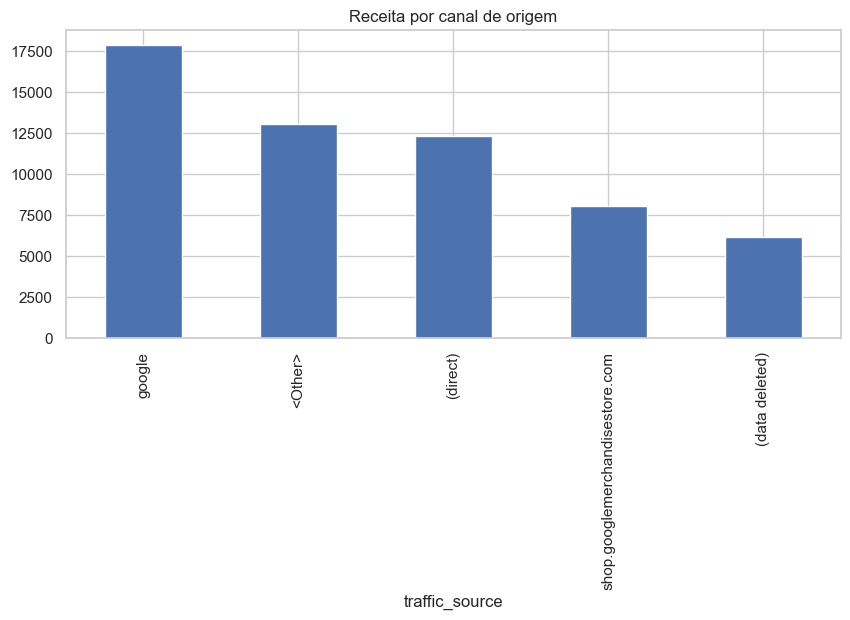

In [9]:
# Receita por canal (source)
df[df['event_name'] == 'purchase'].groupby('traffic_source')['purchase_revenue_in_usd'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10, 4), title='Receita por canal de origem')

In [10]:
# Tempo médio até a compra por sessão
purchase_times = df[df['event_name'] == 'purchase'][['session_id', 'event_timestamp']]
first_event_times = df.groupby('session_id')['event_timestamp'].min().reset_index()
merged = pd.merge(purchase_times, first_event_times, on='session_id', suffixes=('_purchase', '_start'))
merged['tempo_ate_compra_segundos'] = (merged['event_timestamp_purchase'] - merged['event_timestamp_start']) / 1e6
print("Tempo médio até a compra (min):", merged['tempo_ate_compra_segundos'].mean() / 60)

Tempo médio até a compra (min): 0.0


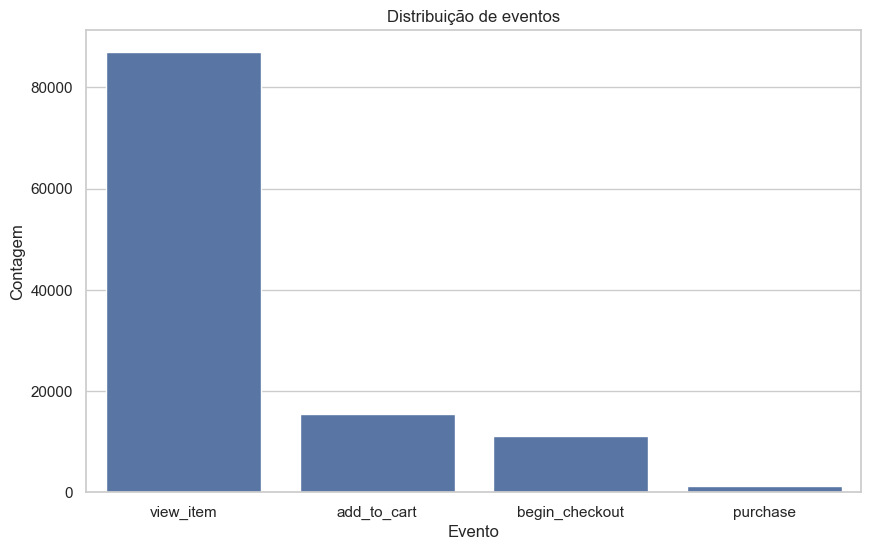

In [11]:
# Visualização da distribuição de eventos
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='event_name', order=df['event_name'].value_counts().index)
plt.title('Distribuição de eventos')
plt.xlabel('Evento')
plt.ylabel('Contagem')
plt.show()

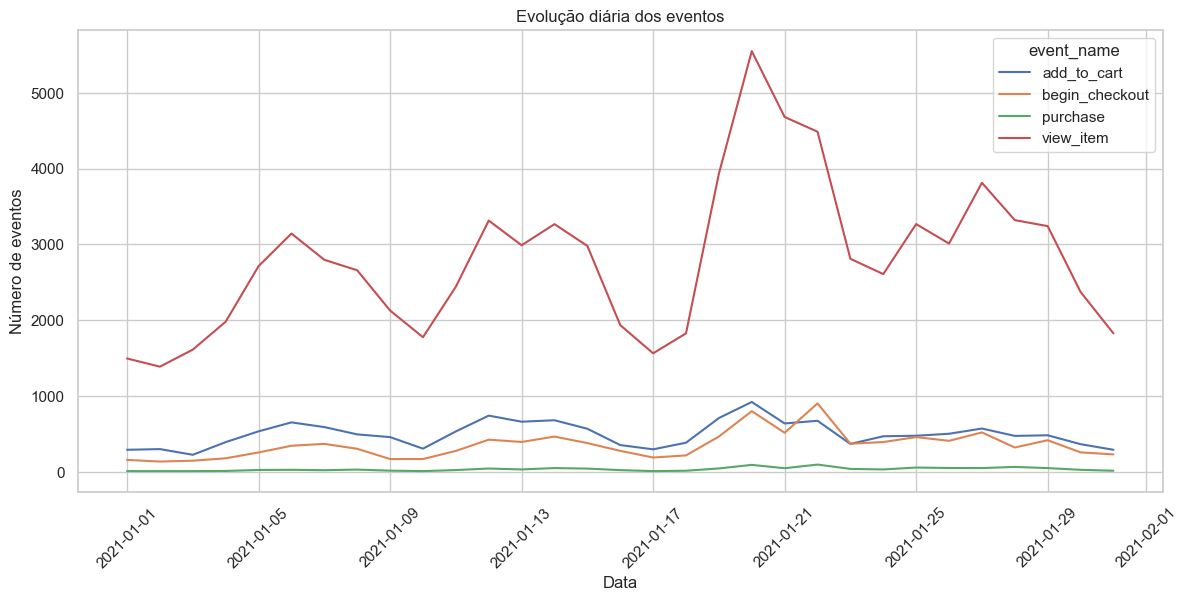

In [12]:
# Seção 5: Análise temporal de eventos
df_eventos = df.groupby(['event_date', 'event_name']).size().reset_index(name='count')
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_eventos, x='event_date', y='count', hue='event_name')
plt.title('Evolução diária dos eventos')
plt.xlabel('Data')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.show()

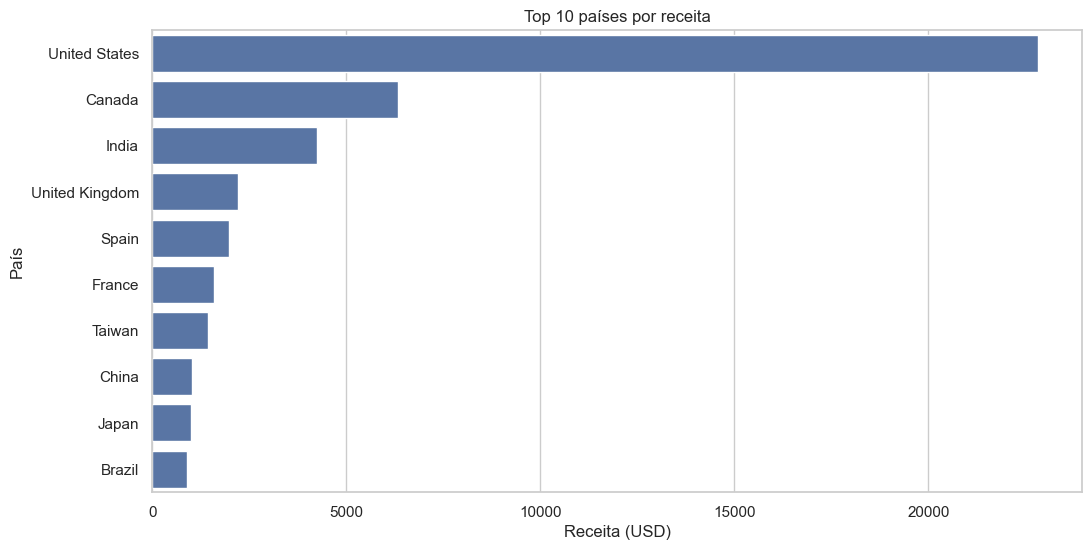

In [13]:
# Seção 6: Receita total por país
df_purchase = df[df['event_name'] == 'purchase']
df_receita_pais = df_purchase.groupby('country')['purchase_revenue_in_usd'].sum().reset_index()
df_receita_pais = df_receita_pais.sort_values(by='purchase_revenue_in_usd', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_receita_pais, x='purchase_revenue_in_usd', y='country')
plt.title('Top 10 países por receita')
plt.xlabel('Receita (USD)')
plt.ylabel('País')
plt.show()

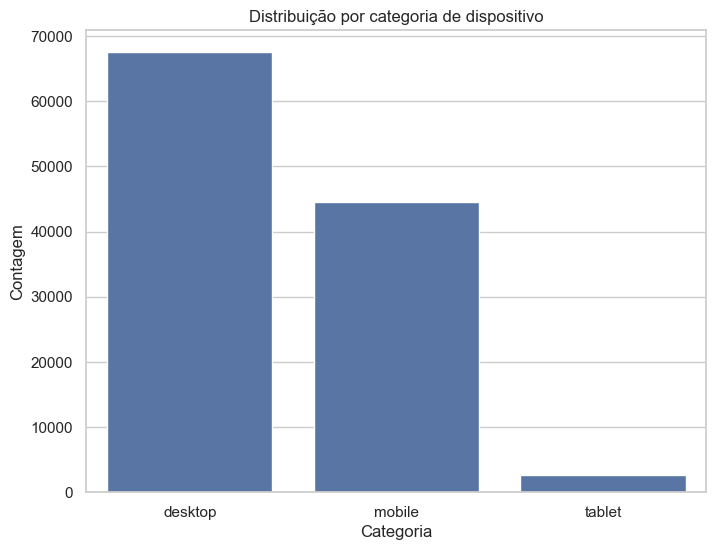

In [14]:
# Seção 7: Dispositivos mais usados
df_device = df['device_category'].value_counts().reset_index()
df_device.columns = ['device_category', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(data=df_device, x='device_category', y='count')
plt.title('Distribuição por categoria de dispositivo')
plt.xlabel('Categoria')
plt.ylabel('Contagem')
plt.show()

In [15]:
# Seção 8: Salvando dataset pré-processado para uso posterior
df.to_csv('../data/dados_ga4_ecommerce.csv', index=False)